# Assignment 10 - Arun Kutty


## Final Test Accuracy - 89.97%


## Script Parameters


In [1]:
# Where are you running this? Can be either 'local' or 'colab'
model_run_location = "colab"

# # Do you want to install the required packages?
# install_required_packages = False
install_required_packages = False if model_run_location == "local" else True

# git repository url
repo_name = "ERAV2-Assignments"
git_repo_url = "https://github.com/ArunNKutty/ERAV2-Assignments.git"

# Is the model being developed or is it in production?
# Can be development or production
code_mode = "production"

# WHich branch are you working on?
branch_name = "main" if code_mode == "development" else "main"
folder_name = "S10"

## Library Installation (Optional)


In [2]:
# # Install any required libraries not present in your working environment

if install_required_packages:

    import sys
    # !{sys.executable} -m pip install torchsummary
    !{sys.executable} -m pip install torch-lr-finder
    !{sys.executable} -m pip install torchinfo

    if model_run_location == 'local':
        %conda install --yes --prefix {sys.prefix} -c conda-forge tqdm
        %conda install --yes --prefix {sys.prefix} -c anaconda ipywidgets
        %conda install --yes --prefix {sys.prefix} -c conda-forge imgaug
        %conda install --yes --prefix {sys.prefix} -c conda-forge albumentations


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 88.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.8 MB/s eta 0:00:00


## Code Procurement


In [3]:
# Mount google drive if running on colab
if model_run_location == 'colab':
    # Get code from github
    !rm -rf {repo_name} && git clone {git_repo_url}

    # Switch to repo folder, Needed to switch branch
    # Switch branch and change to the correct directory
    !cd "{repo_name}" && git checkout {branch_name} && cd "{folder_name}"

Cloning into 'ERAV2-Assignments'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 117 (delta 47), reused 88 (delta 23), pack-reused 0
Receiving objects: 100% (117/117), 1023.68 KiB | 4.16 MiB/s, done.
Resolving deltas: 100% (47/47), done.
Already on 'main'
Your branch is up to date with 'origin/main'.


## Import Libraries


In [4]:
# Import necessary modules (external libs)
import os

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch_lr_finder import LRFinder

# from torchsummary import summary

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
import sys

print(f"CWD: {os.getcwd()}")

if model_run_location == "colab":
    print(f"Appending folder to path in order to detect modules: {folder_name}")
    sys.path.append(f"ERAV2-Assignments/{folder_name}")

CWD: /content
Appending folder to path in order to detect modules: S10


In [6]:
# Use precomputed values for mean and standard deviation of the dataset
CIFAR_MEAN = (0.4915, 0.4823, 0.4468)
CIFAR_STD = (0.2470, 0.2435, 0.2616)

# Create class labels and convert to tuple
CIFAR_CLASSES = tuple(
    c.capitalize()
    for c in [
        "plane",
        "car",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ]
)

In [7]:
import torchinfo

def detailed_model_summary(model, input_size, device):
    """Define a function to print the model summary."""

    # https://github.com/TylerYep/torchinfo
    torchinfo.summary(
        model,
        input_size=input_size,
        batch_dim=0,
        col_names=(
            "input_size",
            "kernel_size",
            "output_size",
            "num_params",
            "trainable",
        ),
        device=device,
        verbose=1,
        col_width=16,
    )

In [8]:
# Import user defined modules
from modules.dataset import split_cifar_data, apply_cifar_image_transformations
# from modules.dataset import CIFAR_MEAN, CIFAR_STD, CIFAR_CLASSES
from modules.custom_resnet import CustomResNet as Net1
from modules.custom_resnet_alt import Net as Net2
# from modules.custom_resnet import detailed_model_summary
from modules.trainer import train_and_test_model
from modules.utils import get_device, save_model, pretty_print_metrics
from modules.visualize import (
    plot_misclassified_images,
    plot_sample_training_images,
    plot_train_test_metrics,
)

## Script Parameters


In [9]:
# Constants naming convention: All caps separated by underscore
# https://realpython.com/python-constants/

# Specify the number of epochs
NUM_EPOCHS = 24

# Set the batch size
BATCH_SIZE = 512

# What is the start LR and weight decay you'd prefer?
PREFERRED_START_LR = 0.3
PREFERRED_WEIGHT_DECAY = 0

# Set seed value for reproducibility
SEED = 2

# Expected accuracy
TARGET_ACCURACY = 90.0

## Get Device


In [10]:
# Functionality to check cuda support and create device is now moved to utils.py
device_support, device = get_device()
print(f"Device created with {device_support}!")

Device created with cuda!


### Reproducibility settings


In [11]:
# For reproducibility
# https://pytorch.org/docs/stable/notes/randomness.html
# https://github.com/pytorch/pytorch/issues/7068
import random
import numpy as np

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

if device_support == "cuda":
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)


# To be passed to dataloader
def _init_fn(worker_id):
    np.random.seed(int(SEED))

## Data Transformations


In [13]:
# Train and test data transformation steps now moved to apply_mnist_image_transformations()

# cutout needs to be half of the image size
cutout_size = 8

train_transforms, test_transforms = apply_cifar_image_transformations(
    mean=CIFAR_MEAN, std=CIFAR_STD, cutout_size=cutout_size
)
train_transforms

/usr/local/lib/python3.10/dist-packages/albumentations/core/composition.py:53: UserWarning: transforms is single transform, but a sequence is expected! Transform will be wrapped into list.
  warnings.warn(


Compose([
  Compose([
    PadIfNeeded(always_apply=False, p=1.0, min_height=4, min_width=1024, pad_height_divisor=None, pad_width_divisor=None, border_mode=4, value=None, mask_value=None),
    RandomCrop(always_apply=False, p=1.0, height=32, width=32),
    HorizontalFlip(always_apply=False, p=0.5),
    CoarseDropout(always_apply=False, p=1.0, max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, fill_value=[0.4915, 0.4823, 0.4468], mask_fill_value=None),
    Normalize(always_apply=False, p=1.0, mean=[0.4915, 0.4823, 0.4468], std=[0.247, 0.2435, 0.2616], max_pixel_value=255.0),
    ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
  ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)

## Train/Test Split


In [14]:
data_path = "../../data"
print(f"Train and test data path: {data_path}")

train_data, test_data = split_cifar_data(data_path, train_transforms, test_transforms)

Train and test data path: ../../data



100%|██████████| 170498071/170498071 [00:03<00:00, 49104292.62it/s]


Extracting ../../data/cifar-10-python.tar.gz to ../../data
Files already downloaded and verified

Mean: [0.4914009  0.48215896 0.4465308 ]
Std: [0.24703279 0.24348423 0.26158753]

Transforms applied on the dataset



## Dataloaders


In [15]:
# calculate the number of workers
num_workers = (os.cpu_count() - 1) if os.cpu_count() > 3 else 2
# If run_mode is local, use only 2 workers
num_workers = num_workers if model_run_location == "colab" else 0
print(f"Number of workers: {num_workers}")

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=num_workers,
    pin_memory=True,
    worker_init_fn=_init_fn,
)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

Number of workers: 2


In [16]:
# Get class mapping for the dataset
classes = CIFAR_CLASSES
print(classes)

('Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')


## Sample Training Images


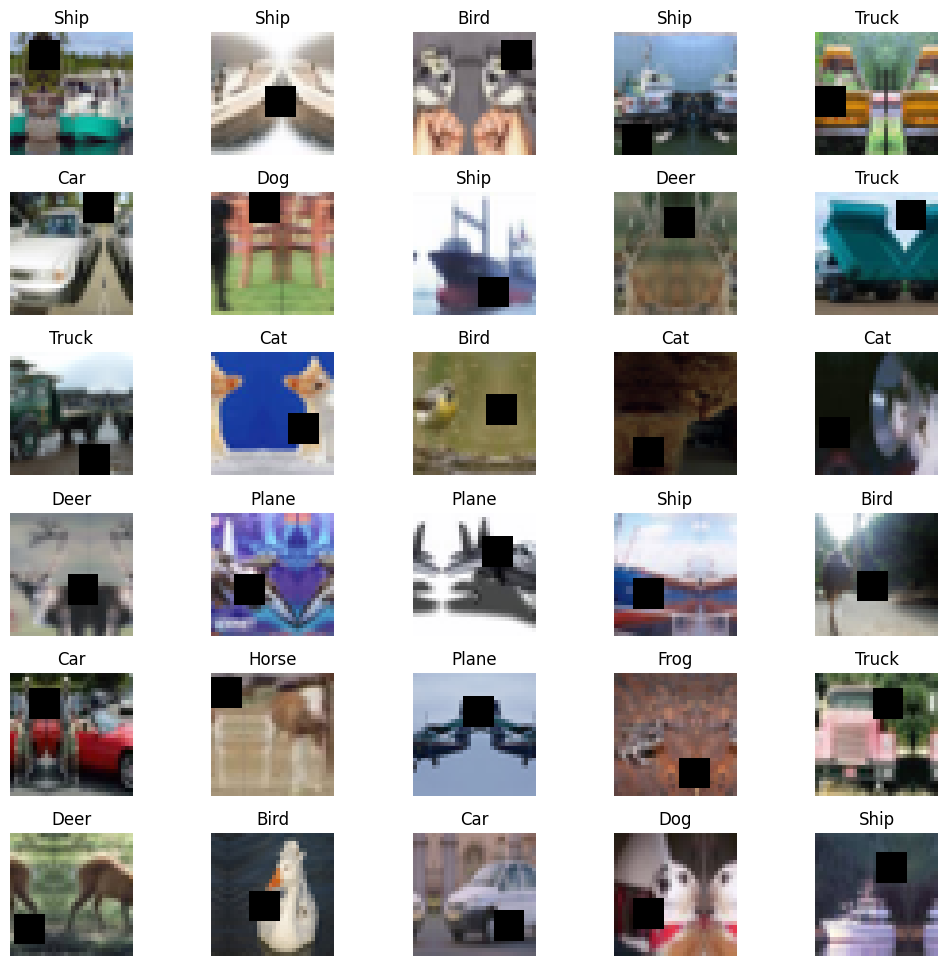

In [17]:
# Get a batch of training data from train_loader
batch_data, batch_label = next(iter(train_loader))

# Plot 30 sample images from the training data along with their labels
# plot_sample_training_images() imported from utils.py
fig, axs = plot_sample_training_images(
    batch_data, batch_label, class_label=classes, num_images=30
)
plt.show()

## Model Summary


In [21]:
# Model class is imported from model.py

# Send the model to device
model = Net1().to(device)

# enable printing shape
model.print_shape = True

# # Print the model summary by specifying the input size
# summary(model, input_size=(3, 32, 32))
detailed_model_summary(model, input_size=(3, 32, 32), device=device)

# disable printing shape for cleaner test train output
model.print_shape = False

PrepLayer 
	 torch.Size([1, 64, 32, 32]) 

Layer 1, X 
	 torch.Size([1, 128, 16, 16]) 

Layer 1, R1 
	 torch.Size([1, 128, 16, 16]) 

Layer 1, X + R1 
	 torch.Size([1, 128, 16, 16]) 

Layer 2 
	 torch.Size([1, 256, 8, 8]) 

Layer 3, X 
	 torch.Size([1, 512, 4, 4]) 

Layer 3, R2 
	 torch.Size([1, 512, 4, 4]) 

Layer 3, X + R2 
	 torch.Size([1, 512, 4, 4]) 

Max Pooling 
	 torch.Size([1, 512, 1, 1]) 

Reshape before FC 
	 torch.Size([1, 512]) 

After FC 
	 torch.Size([1, 10]) 

Layer (type:depth-idx)                   Input Shape      Kernel Shape     Output Shape     Param #          Trainable
CustomResNet                             [1, 3, 32, 32]   --               [1, 10]          --               True
├─Sequential: 1-1                        [1, 3, 32, 32]   --               [1, 64, 32, 32]  --               True
│    └─Conv2d: 2-1                       [1, 3, 32, 32]   [3, 3]           [1, 64, 32, 32]  1,728            True
│    └─BatchNorm2d: 2-2                  [1, 64, 32, 32]  

## Train and Test


### Optimizer and Loss Function


In [22]:
# Create optimizer and scheduler
# Use ADAM
# https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
optimizer = optim.Adam(
    model.parameters(), lr=PREFERRED_START_LR, weight_decay=PREFERRED_WEIGHT_DECAY
)

# Define criteria function
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
criterion = torch.nn.CrossEntropyLoss()

### Find Learning Rate


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.87E-02


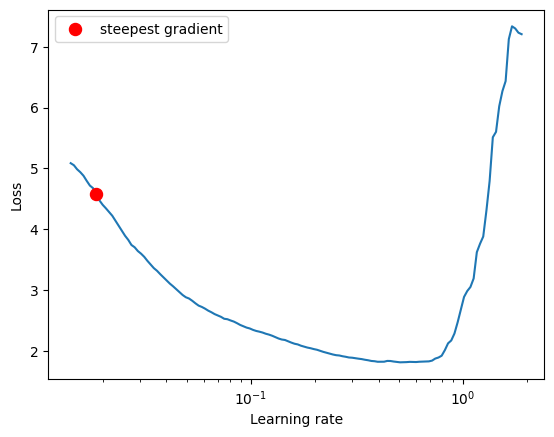

0.018679135990207825


In [23]:
# Use LR Finder to find the best starting learning rate
# https://github.com/davidtvs/pytorch-lr-finder
# https://github.com/davidtvs/pytorch-lr-finder#notes
# https://github.com/davidtvs/pytorch-lr-finder/blob/master/torch_lr_finder/lr_finder.py

# Create LR finder object
lr_finder = LRFinder(model, optimizer, criterion)
lr_finder.range_test(train_loader=train_loader, end_lr=10, num_iter=200, start_lr=1e-2)
# https://github.com/davidtvs/pytorch-lr-finder/issues/88
plot, suggested_lr = lr_finder.plot(suggest_lr=True)
lr_finder.reset()
plot.figure.savefig("LRFinder - Suggested Max LR.png")
print(suggested_lr)

{'lr': [0.01, 0.010353218432956621, 0.010718913192051278, 0.01109752496412072, 0.011489510001873092, 0.011895340673703196, 0.012315506032928256, 0.012750512407130132, 0.013200884008314179, 0.013667163564620067, 0.01414991297434576, 0.01464971398307286, 0.015167168884709228, 0.015702901247293774, 0.01625755666443794, 0.016831803533309566, 0.017426333860096503, 0.01804186409392072, 0.018679135990207825, 0.01933891750455231, 0.020022003718155847, 0.020729217795953714, 0.021461411978584043, 0.02221946860939524, 0.023004301197729178, 0.023816855519761582, 0.024658110758226034, 0.025529080682395178, 0.02643081486974105, 0.027364399970746703, 0.02833096101839324, 0.02933166278390045, 0.030367711180354584, 0.031440354715915, 0.03255088599835058, 0.03370064329271929, 0.03489101213406773, 0.03612342699709432, 0.03739937302478798, 0.03872038781812555, 0.040088063288984656, 0.04150404757850476, 0.04297004704320841, 0.04448782831127585, 0.046059220411451066, 0.0476861169771447, 0.04937047852839003,

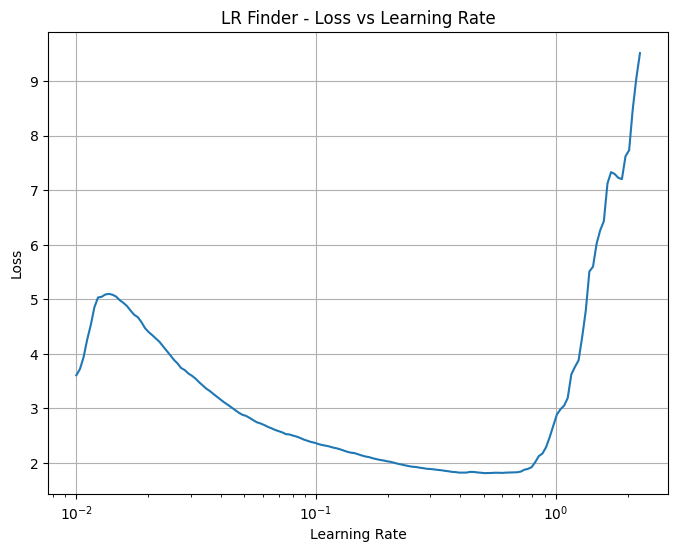

In [25]:
print(lr_finder.history)
# Plot the history graph
plt.figure(figsize=(8, 6))
plt.plot(lr_finder.history['lr'], lr_finder.history['loss'])
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('LR Finder - Loss vs Learning Rate')
plt.grid(True)
plt.savefig("LRFinder - History Graph.png")
plt.show()
# suggested_lr = lr_finder.history['lr'][-1]

### Scheduler


In [28]:
# # Learning rate scheduler based on plateau
# # https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
# scheduler = ReduceLROnPlateau(
#     optimizer, mode="min", factor=0.5, patience=1, threshold=0.03, verbose=False
# )

# suggested_lr = 0.2
print(f"Suggested Max LR: {suggested_lr}")

# Learning rate scheduler based on OneCycleLR
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html
scheduler = OneCycleLR(
    optimizer,
    max_lr=suggested_lr,
    steps_per_epoch=len(train_loader),
    epochs=NUM_EPOCHS,
    pct_start=5 / NUM_EPOCHS,
    div_factor=5,
    three_phase=False,
    final_div_factor=20,
    verbose=False,
)

Suggested Max LR: 0.018679135990207825


### Train and test model


In [31]:
# Create a dictionary of lists for misclassified images, generated predictions and ground truth
misclassified_image_data = {"images": [], "ground_truths": [], "predicted_vals": []}

# Run the model for NUM_EPOCHS
results = train_and_test_model(
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    model=model,
    device=device,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    misclassified_image_data=misclassified_image_data,
)



Batch size: 512, Total epochs: 24


Epoch 1


Train: Loss=0.2288, Batch_id=97, Accuracy=92.35: 100%|██████████| 98/98 [00:22<00:00,  4.30it/s]


Test set: Average loss: 0.0008,  Accuracy: 8764/10000  (87.64%)


Epoch 2


Train: Loss=0.2083, Batch_id=97, Accuracy=92.70: 100%|██████████| 98/98 [00:22<00:00,  4.34it/s]


Test set: Average loss: 0.0007,  Accuracy: 8856/10000  (88.56%)


Epoch 3


Train: Loss=0.2422, Batch_id=97, Accuracy=92.82: 100%|██████████| 98/98 [00:21<00:00,  4.49it/s]


Test set: Average loss: 0.0008,  Accuracy: 8812/10000  (88.12%)


Epoch 4


Train: Loss=0.2148, Batch_id=97, Accuracy=92.92: 100%|██████████| 98/98 [00:21<00:00,  4.50it/s]


Test set: Average loss: 0.0007,  Accuracy: 8891/10000  (88.91%)


Epoch 5


Train: Loss=0.1793, Batch_id=97, Accuracy=93.37: 100%|██████████| 98/98 [00:21<00:00,  4.51it/s]


Test set: Average loss: 0.0008,  Accuracy: 8860/10000  (88.60%)


Epoch 6


Train: Loss=0.1674, Batch_id=97, Accuracy=93.99: 100%|██████████| 98/98 [00:22<00:00,  4.26it/s]


Test set: Average loss: 0.0008,  Accuracy: 8866/10000  (88.66%)


Epoch 7


Train: Loss=0.1887, Batch_id=97, Accuracy=94.29: 100%|██████████| 98/98 [00:22<00:00,  4.39it/s]


Test set: Average loss: 0.0008,  Accuracy: 8868/10000  (88.68%)


Epoch 8


Train: Loss=0.1561, Batch_id=97, Accuracy=94.19: 100%|██████████| 98/98 [00:22<00:00,  4.45it/s]


Test set: Average loss: 0.0008,  Accuracy: 8818/10000  (88.18%)


Epoch 9


Train: Loss=0.1807, Batch_id=97, Accuracy=94.58: 100%|██████████| 98/98 [00:22<00:00,  4.40it/s]


Test set: Average loss: 0.0008,  Accuracy: 8891/10000  (88.91%)


Epoch 10


Train: Loss=0.1560, Batch_id=97, Accuracy=94.89: 100%|██████████| 98/98 [00:22<00:00,  4.32it/s]


Test set: Average loss: 0.0008,  Accuracy: 8898/10000  (88.98%)


Epoch 11


Train: Loss=0.1591, Batch_id=97, Accuracy=94.45: 100%|██████████| 98/98 [00:22<00:00,  4.36it/s]


Test set: Average loss: 0.0008,  Accuracy: 8869/10000  (88.69%)


Epoch 12


Train: Loss=0.1865, Batch_id=97, Accuracy=94.22: 100%|██████████| 98/98 [00:22<00:00,  4.32it/s]


Test set: Average loss: 0.0009,  Accuracy: 8837/10000  (88.37%)


Epoch 13


Train: Loss=0.1181, Batch_id=97, Accuracy=94.96: 100%|██████████| 98/98 [00:22<00:00,  4.30it/s]


Test set: Average loss: 0.0009,  Accuracy: 8813/10000  (88.13%)


Epoch 14


Train: Loss=0.1665, Batch_id=97, Accuracy=95.00: 100%|██████████| 98/98 [00:22<00:00,  4.28it/s]


Test set: Average loss: 0.0008,  Accuracy: 8855/10000  (88.55%)


Epoch 15


Train: Loss=0.1346, Batch_id=97, Accuracy=95.64: 100%|██████████| 98/98 [00:22<00:00,  4.33it/s]


Test set: Average loss: 0.0007,  Accuracy: 8984/10000  (89.84%)


Epoch 16


Train: Loss=0.0987, Batch_id=97, Accuracy=95.50: 100%|██████████| 98/98 [00:22<00:00,  4.36it/s]


Test set: Average loss: 0.0008,  Accuracy: 8950/10000  (89.50%)


Epoch 17


Train: Loss=0.1043, Batch_id=97, Accuracy=95.93: 100%|██████████| 98/98 [00:22<00:00,  4.35it/s]


Test set: Average loss: 0.0008,  Accuracy: 8909/10000  (89.09%)


Epoch 18


Train: Loss=0.0865, Batch_id=97, Accuracy=95.96: 100%|██████████| 98/98 [00:22<00:00,  4.28it/s]


Test set: Average loss: 0.0008,  Accuracy: 8997/10000  (89.97%)


Epoch 19


Train: Loss=0.1236, Batch_id=97, Accuracy=95.84: 100%|██████████| 98/98 [00:21<00:00,  4.50it/s]


Test set: Average loss: 0.0008,  Accuracy: 8942/10000  (89.42%)


Epoch 20


Train: Loss=0.0852, Batch_id=97, Accuracy=96.17: 100%|██████████| 98/98 [00:21<00:00,  4.48it/s]


Test set: Average loss: 0.0008,  Accuracy: 8990/10000  (89.90%)


Epoch 21


Train: Loss=0.1630, Batch_id=97, Accuracy=96.21: 100%|██████████| 98/98 [00:21<00:00,  4.53it/s]


Test set: Average loss: 0.0009,  Accuracy: 8914/10000  (89.14%)


Epoch 22


Train: Loss=0.0977, Batch_id=97, Accuracy=96.08: 100%|██████████| 98/98 [00:22<00:00,  4.41it/s]


Test set: Average loss: 0.0009,  Accuracy: 8838/10000  (88.38%)


Epoch 23


Train: Loss=0.1746, Batch_id=97, Accuracy=96.59: 100%|██████████| 98/98 [00:22<00:00,  4.32it/s]


Test set: Average loss: 0.0008,  Accuracy: 8936/10000  (89.36%)


Epoch 24


Train: Loss=0.0861, Batch_id=97, Accuracy=96.52: 100%|██████████| 98/98 [00:22<00:00,  4.28it/s]


Test set: Average loss: 0.0009,  Accuracy: 8946/10000  (89.46%)




In [32]:
# Pretty print train and test accuracy and loss values for each epoch
pretty_print_metrics(num_epochs=NUM_EPOCHS, results=results)

Epoch: 01, Train Loss: 0.2134, Test Loss: 0.0008, Train Accuracy: 92.3520, Test Accuracy: 87.6400
Epoch: 02, Train Loss: 0.2077, Test Loss: 0.0007, Train Accuracy: 92.7040, Test Accuracy: 88.5600
Epoch: 03, Train Loss: 0.2011, Test Loss: 0.0008, Train Accuracy: 92.8180, Test Accuracy: 88.1200
Epoch: 04, Train Loss: 0.1976, Test Loss: 0.0007, Train Accuracy: 92.9220, Test Accuracy: 88.9100
Epoch: 05, Train Loss: 0.1866, Test Loss: 0.0008, Train Accuracy: 93.3720, Test Accuracy: 88.6000
Epoch: 06, Train Loss: 0.1704, Test Loss: 0.0008, Train Accuracy: 93.9940, Test Accuracy: 88.6600
Epoch: 07, Train Loss: 0.1617, Test Loss: 0.0008, Train Accuracy: 94.2920, Test Accuracy: 88.6800
Epoch: 08, Train Loss: 0.1638, Test Loss: 0.0008, Train Accuracy: 94.1940, Test Accuracy: 88.1800
Epoch: 09, Train Loss: 0.1571, Test Loss: 0.0008, Train Accuracy: 94.5780, Test Accuracy: 88.9100
Epoch: 10, Train Loss: 0.1472, Test Loss: 0.0008, Train Accuracy: 94.8880, Test Accuracy: 88.9800
Epoch: 11, Train Los

## Metrics


Expected accuracy: 90.0%
Plotting accuracy and loss graphs.


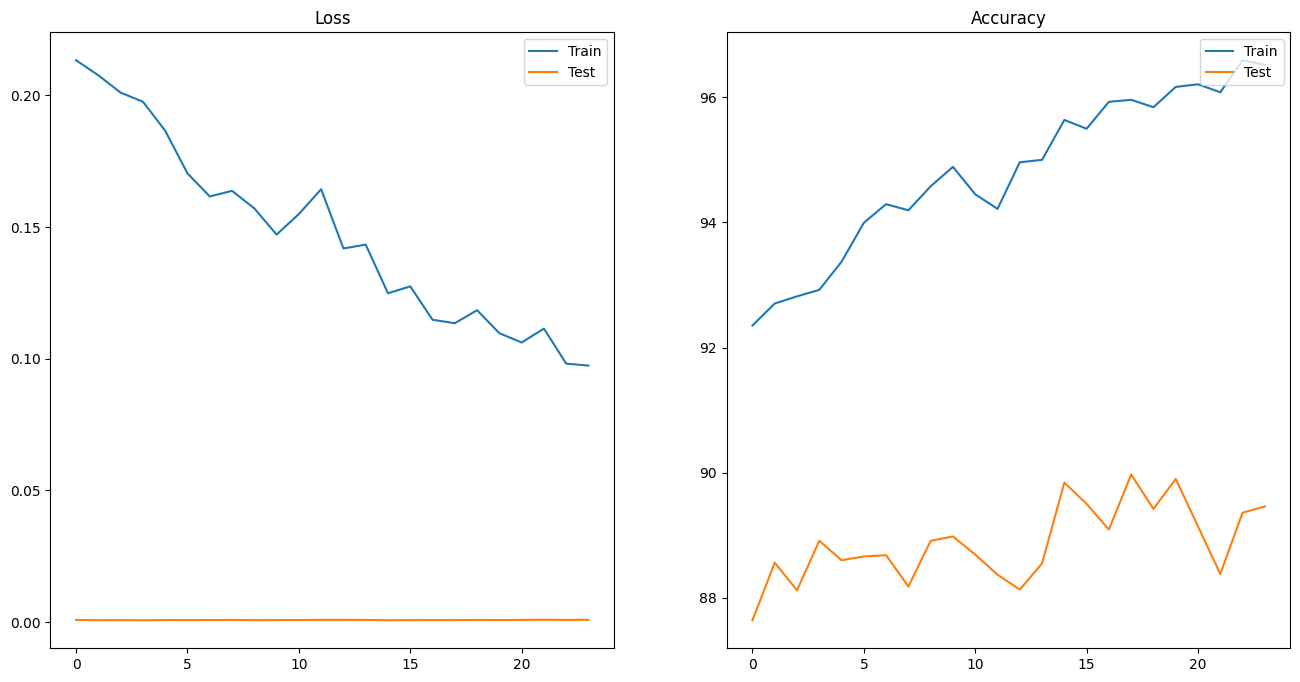

In [33]:
# Print expected accuracy for easier reference
print(f"Expected accuracy: {TARGET_ACCURACY}%")

# Plot the accuracy and loss graphs using data and plot_train_test_metrics() from model.py
print("Plotting accuracy and loss graphs.")
fig, axs = plot_train_test_metrics(results)
plt.show()
# plt.savefig("Loss and Accuracy Metrics.png")

## Save model


In [34]:
# Save model
print("Saving the model as the training is complete!")
save_model(
    epoch=NUM_EPOCHS,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    batch_size=BATCH_SIZE,
    criterion=criterion,
    file_name="model_last_epoch.pth",
)

Saving the model as the training is complete!


## Show incorrect images


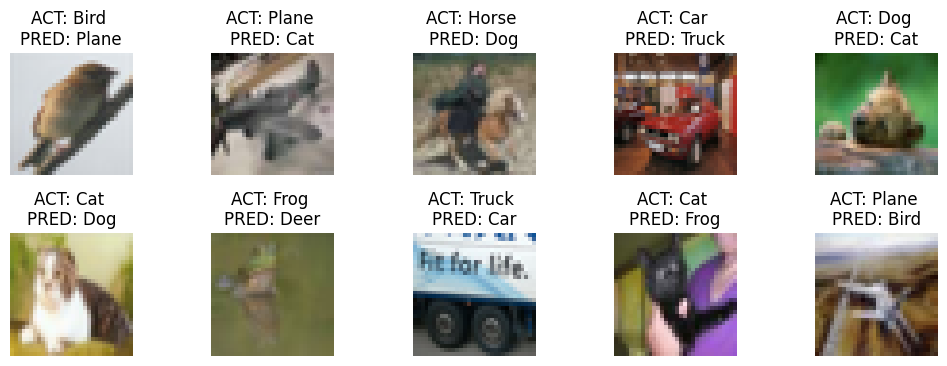

<Figure size 640x480 with 0 Axes>

In [36]:
# Plot misclassified images
fig, axs = plot_misclassified_images(
    data=misclassified_image_data, class_label=classes, num_images=10
)
plt.show()
plt.savefig("Misclassified Images.png")